In [20]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)
 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd

COLOR_PALETTE = [
    "#0070bc",
    "#05a298",
    "#d06b6d",
    "#a8e667",
    "#D3D3D3",
    "#57832e",
    "#56ebd3",
    "#0a4f4e",
    "#9ecbf4",
]

sns.set_theme(style="white")
plt.rcParams["figure.figsize"] = (12, 6)
sns.set_palette(COLOR_PALETTE)
pd.set_option("display.max_columns", None)


CAMBIOS_GLOSAS = {
    "Región Del Bíobío": "Región del Bío-Bío",
    "Región Metropolitana de Santiago": "Región Metropolitana de Santiago",
    "Región del Libertador General Bernardo O'Higgins": "Región del Libertador Bernardo O'Higgins",
    "Región De Antofagasta": "Región de Antofagasta",
    "Región De Los Lagos": "Región de Los Lagos",
    "Región Del Maule": "Región del Maule",
    "Región De Valparaíso": "Región de Valparaíso",
    "Región De Arica y Parinacota": "Región de Arica y Parinacota",
    "Región De Tarapacá": "Región de Tarapacá",
    "Región Aysén del General Carlos Ibáñez del Campo": "Región de Aysén del Gral.Ibañez del Campo",
    "Región De Coquimbo": "Región de Coquimbo",
    "Región De Magallanes y de La Antártica Chilena": "Región de Magallanes y Antártica Chilena",
    "Región De La Araucanía": "Región de La Araucanía",
    "Región De Atacama": "Región de Atacama",
    "Región De Ñuble": "Región de Ñuble",
    "Región De Los Ríos": "Región de Los Ríos",
}

In [39]:
df = pd.read_csv("../data/processed/df_procesada.csv")

In [40]:
# Eliminamos las filas que no tienen fecha de evaluación
df_limpia = df.dropna(subset="fecha_1_evaluacion").copy()
df_limpia = df_limpia.query("anio_1_evaluacion >= 2000 and anio_1_evaluacion <= 2022")

# Cambia glosas de la region
df_limpia["region"] = df_limpia["region"].str.replace(", Chile", "")
df_limpia["region"] = df_limpia["region"].replace(CAMBIOS_GLOSAS)

# Formatea fechas
df_limpia["fecha_1_evaluacion"] = pd.to_datetime(df_limpia["fecha_1_evaluacion"])
df_limpia["f_nac"] = pd.to_datetime(df_limpia["f_nac"])
df_limpia["edad_1_evaluacion_calc"] = (
    df_limpia["fecha_1_evaluacion"] - df_limpia["f_nac"]
).dt.days / 365

# Formatea previsiones
df_limpia["prevision"] = df_limpia["prevision"].str.upper()
df_limpia["prevision"] = df_limpia["prevision"].replace({"FONASA A": "A", "FNS A": "A"})

In [82]:
# Obtiene la cantidad de pacientes anuales
cantidad_de_pacientes = df_limpia.groupby("anio_1_evaluacion")["rut"].nunique()
total_pacientes = df_limpia["rut"].nunique()

# Obtiene la distribucion de la prevision a lo largo de los anios
prevision = df_limpia.groupby(["prevision"])["rut"].nunique()
# prevision.loc["Total", :] =  prevision.sum()

# Obtiene la distribucion de la 1era edad de consulta
edad_primera_consulta = df_limpia.groupby("anio_1_evaluacion")["edad_1_evaluacion_calc"].describe()

# Obtiene el desglose por region
desglose_por_region = df_limpia.groupby("region")["rut"].nunique()

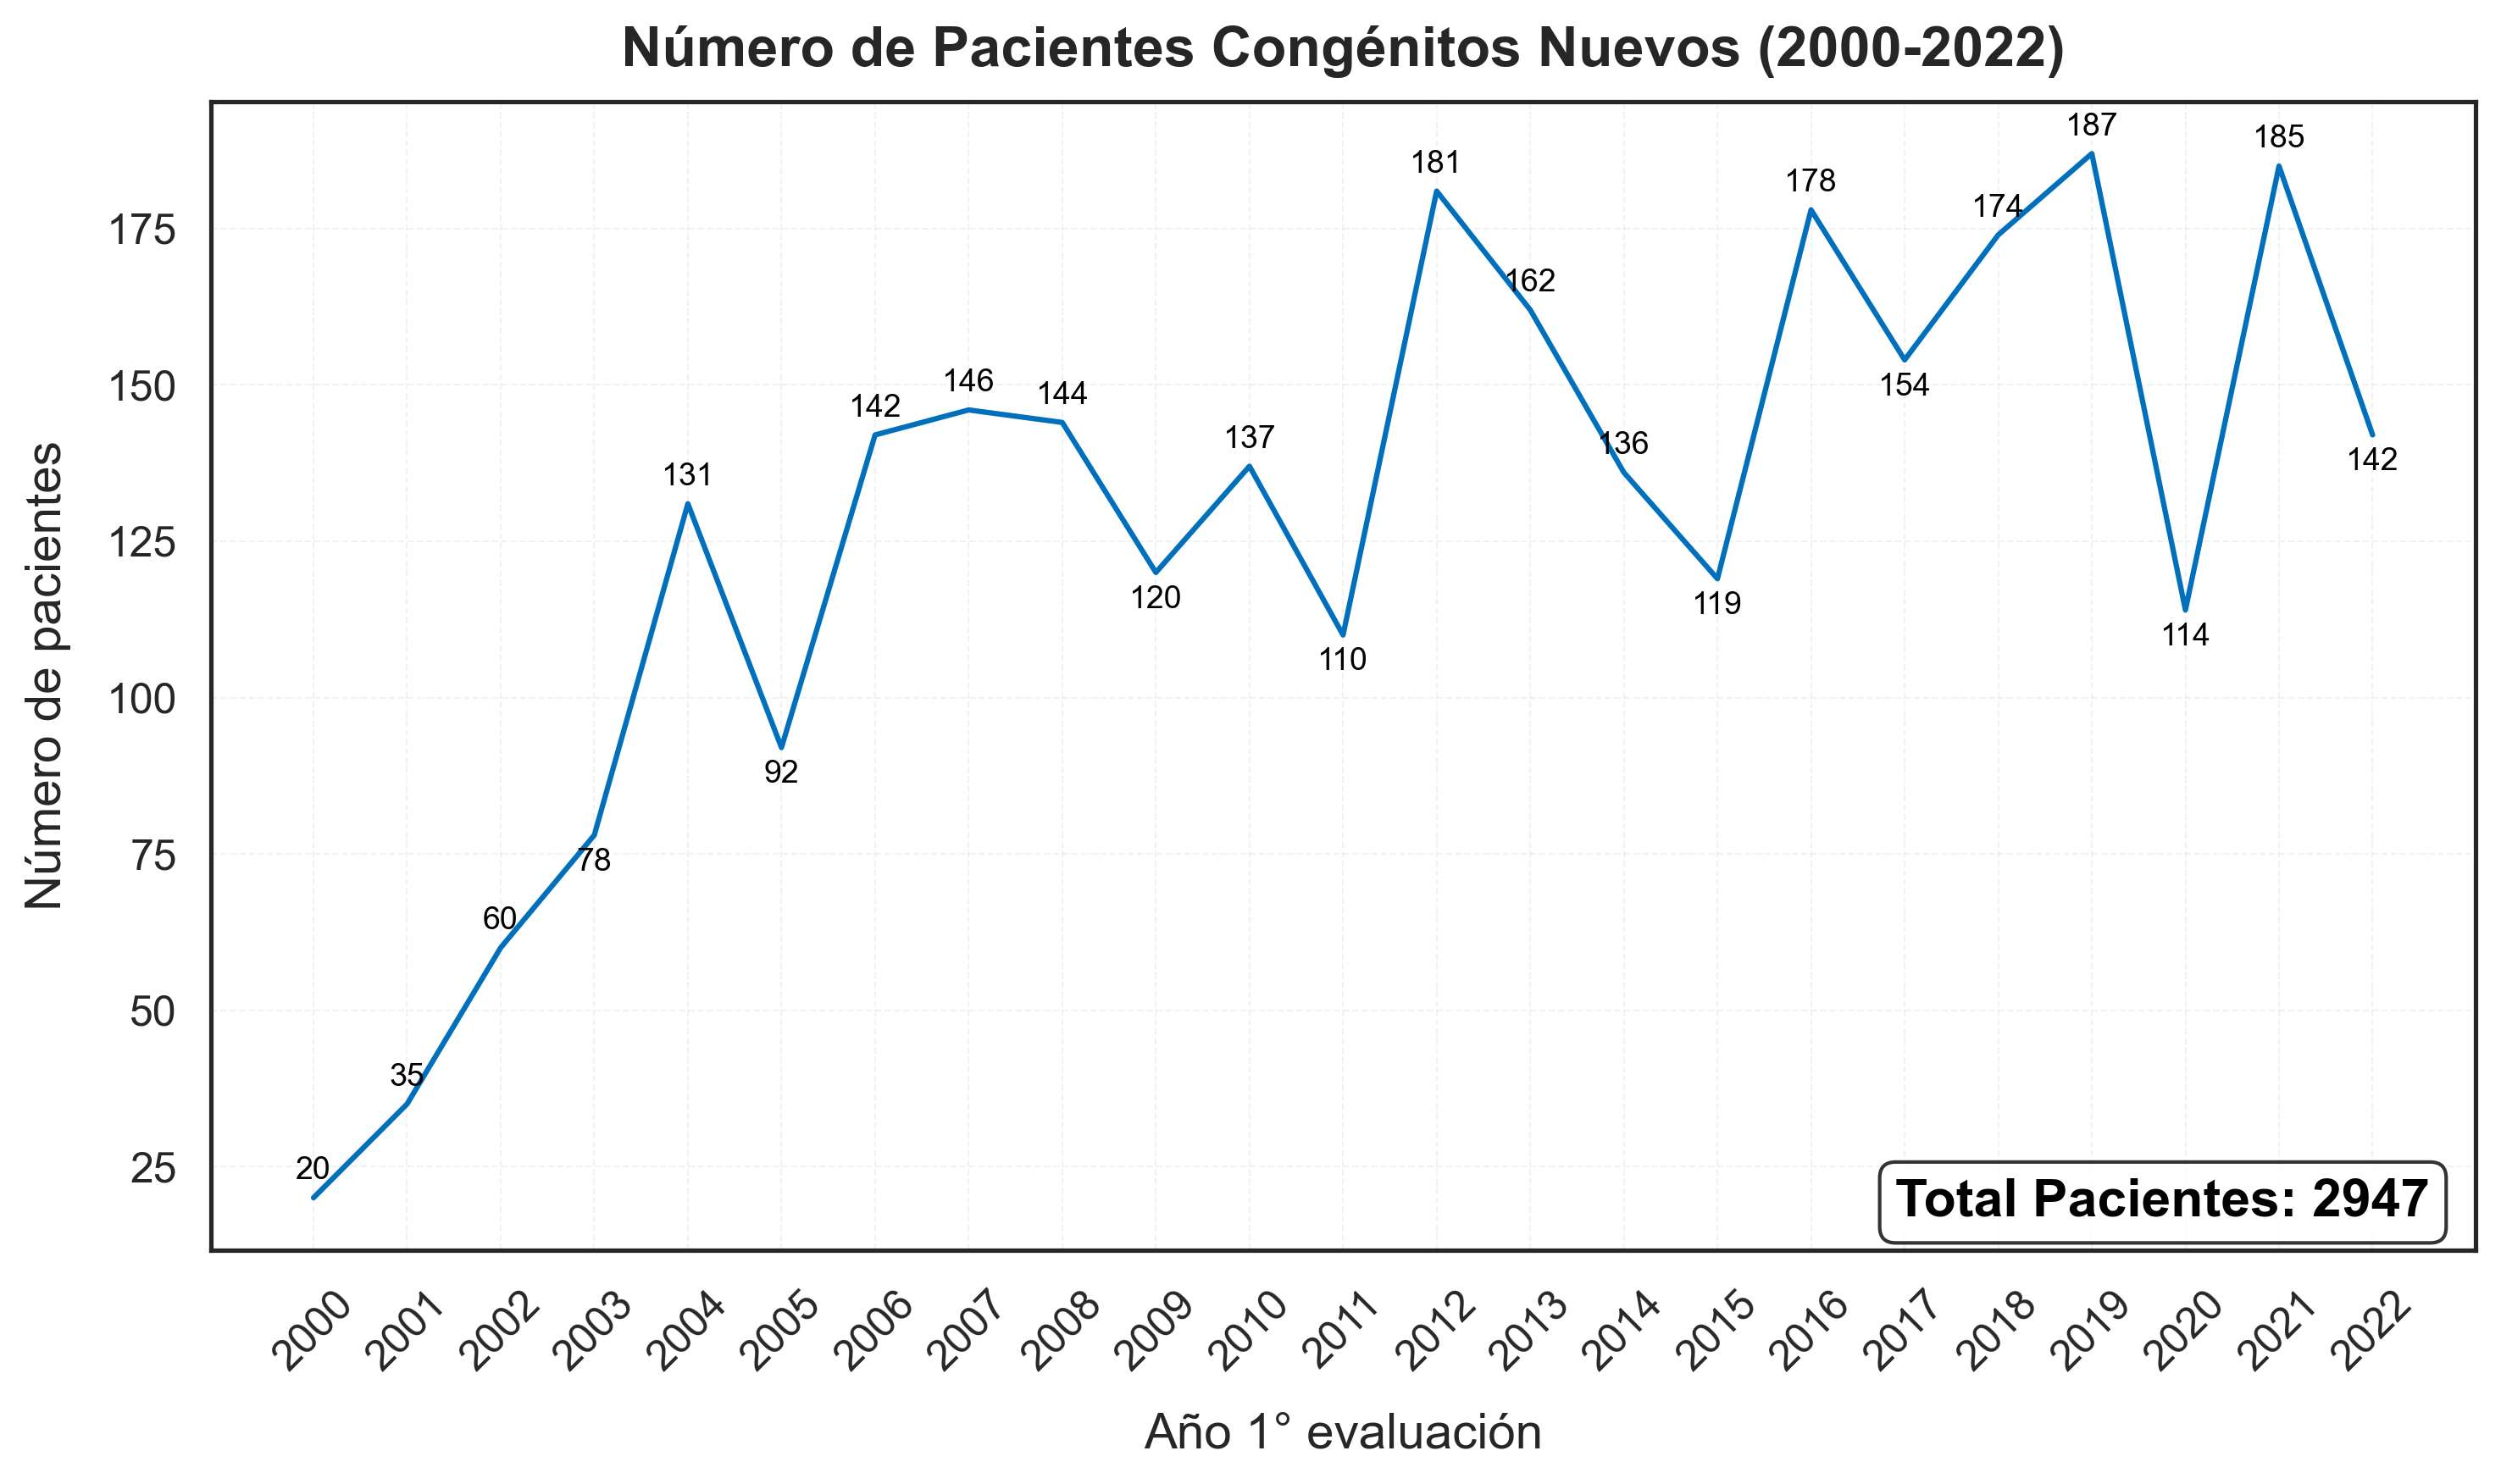

In [88]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Plot the data
cantidad_de_pacientes.plot(ax=ax)

# Set titles and labels
ax.set_title(
    "Número de Pacientes Congénitos Nuevos (2000-2022)", fontsize=16, weight="bold", pad=10
)
ax.set_xlabel("Año 1° evaluación", fontsize=14, labelpad=10)
ax.set_ylabel("Número de pacientes", fontsize=14, labelpad=10)

# Rotate x-axis labels for clarity
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Add labels above each point with boundary checks
ANIOS_POR_ABAJO = [2003, 2005, 2009, 2011, 2015, 2017, 2020, 2022]
ANIOS_POR_ARRIBA = [
    2000,
    2001,
    2002,
    2004,
    2006,
    2007,
    2008,
    2010,
    2012,
    2013,
    2014,
    2016,
    2018,
    2019,
    2021,
]

for anio in ANIOS_POR_ABAJO:
    value = cantidad_de_pacientes.loc[anio]
    ax.text(
        x=anio,
        y=value - 2,
        s=str(value),
        va="top",
        ha="center",  # Center-align horizontally
        fontsize=9,
        color="black",
    )

for anio in ANIOS_POR_ARRIBA:
    value = cantidad_de_pacientes.loc[anio]
    ax.text(
        x=anio,
        y=value + 2,
        s=str(value),
        va="bottom",
        ha="center",  # Center-align horizontally
        fontsize=9,
        color="black",
    )

# Add a text box in the lower right corner
text_box_content = f"Total Pacientes: {total_pacientes}"

ax.text(
    x=0.98,  # X-coordinate in figure-relative coordinates (1.0 is the far right)
    y=0.02,  # Y-coordinate in figure-relative coordinates (0.0 is the bottom)
    s=text_box_content,  # The text to display
    fontsize=15,
    color="black",
    weight="bold",
    ha="right",  # Align text to the right
    va="bottom",  # Align text to the bottom
    bbox=dict(
        boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8
    ),  # Add a border and background
    transform=ax.transAxes,  # Use axis-relative coordinates
)

# Adjust x-axis tick frequency
ax.set_xticks(cantidad_de_pacientes.index)  # Show all years (or adjust as needed)

# Add a grid for better readability
ax.grid(visible=True, which="major", linestyle="--", linewidth=0.5, color="gray", alpha=0.1)

# Adjust layout for better spacing
fig.tight_layout()

# Save the figure
plt.savefig("../reports/figures/numero_de_pacientes.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

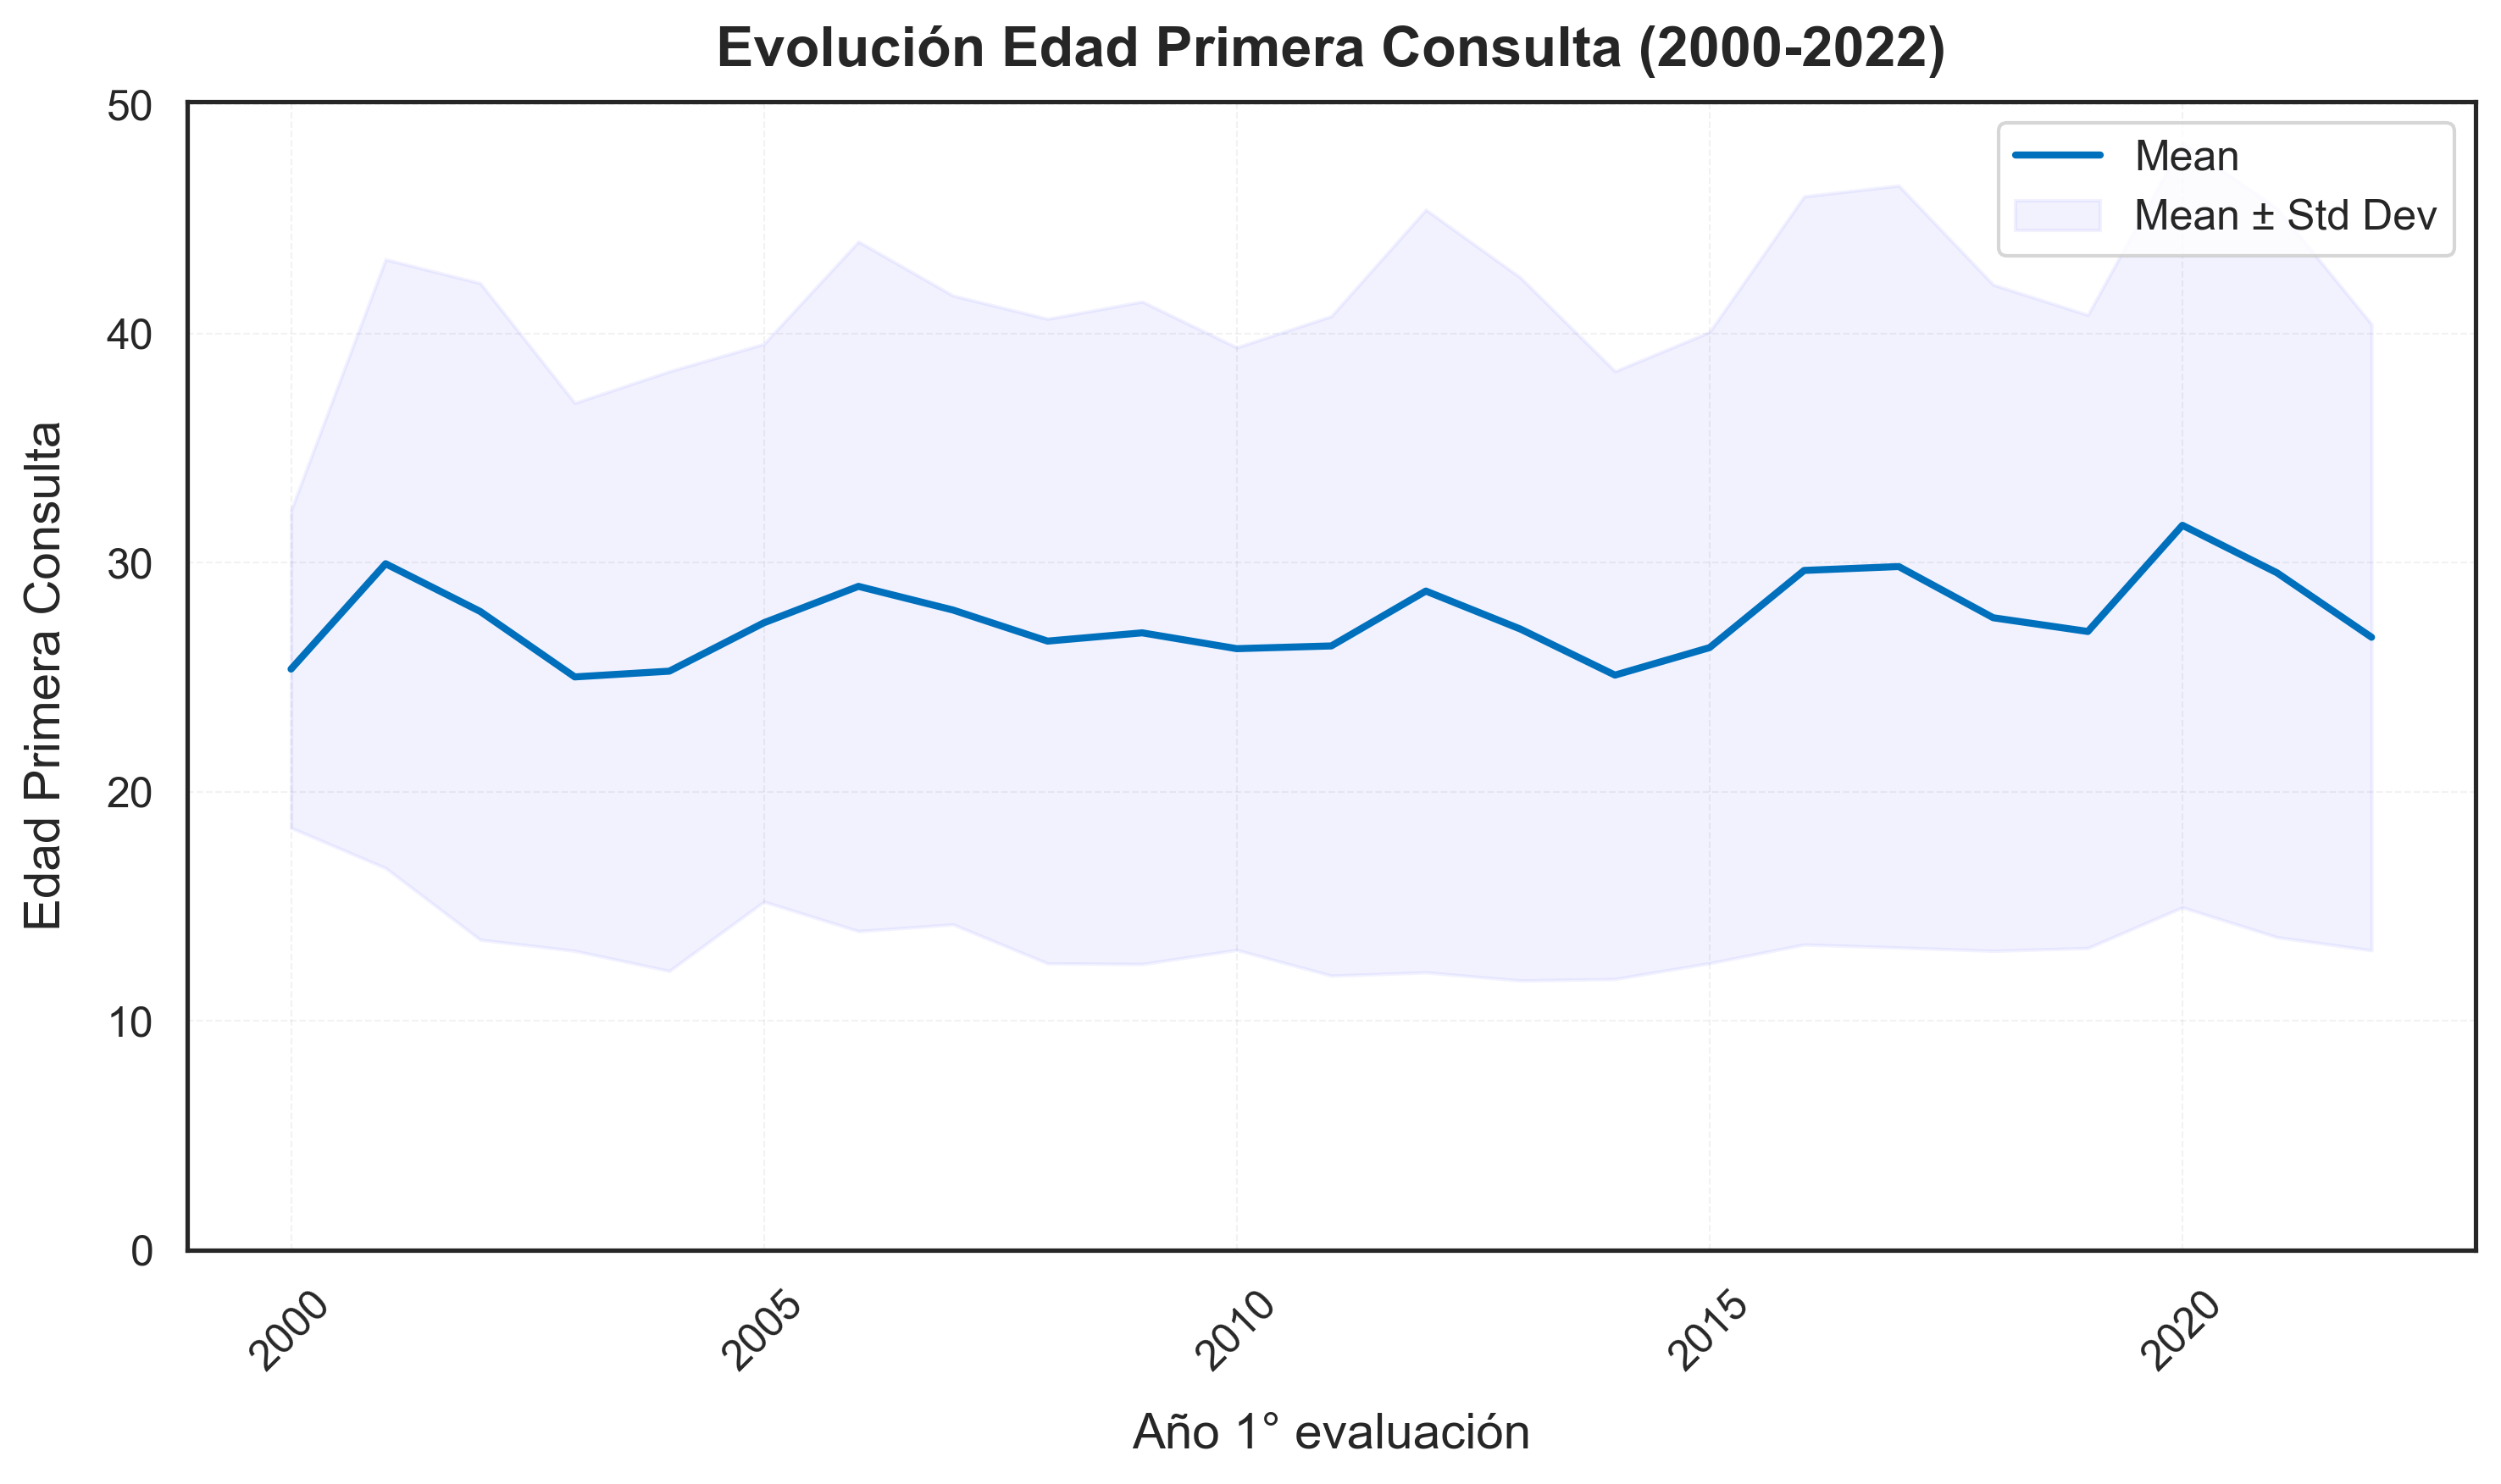

In [98]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Plot the mean as a line
ax.plot(
    edad_primera_consulta.index, 
    edad_primera_consulta["mean"], 
    label="Mean", 
    color="#0070bc", 
    linewidth=2
)

# # Add shaded areas for min and max
# ax.fill_between(
#     edad_primera_consulta.index, 
#     edad_primera_consulta["min"], 
#     edad_primera_consulta["max"], 
#     color="blue", 
#     alpha=0.1, 
#     label="Min-Max Range"
# )

# Optionally, add shaded areas for mean ± std
if "std" in edad_primera_consulta.columns:
    ax.fill_between(
        edad_primera_consulta.index,
        edad_primera_consulta["mean"] - edad_primera_consulta["std"],
        edad_primera_consulta["mean"] + edad_primera_consulta["std"],
        color="blue",
        alpha=0.05,
        label="Mean ± Std Dev"
    )

# Customize plot
ax.set_title(
    "Evolución Edad Primera Consulta (2000-2022)", fontsize=16, weight="bold", pad=10
)
ax.set_xlabel("Año 1° evaluación", fontsize=14, labelpad=10)
ax.set_ylabel("Edad Primera Consulta", fontsize=14, labelpad=10)

# Rotate x-axis labels for clarity
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

plt.ylim(bottom=0)

# Add a grid for better readability
ax.grid(visible=True, which="major", linestyle="--", linewidth=0.5, color="gray", alpha=0.1)

# Add a legend
ax.legend(fontsize=12)

fig.tight_layout()

# Save the figure
plt.savefig("../reports/figures/edad_primera_consulta.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


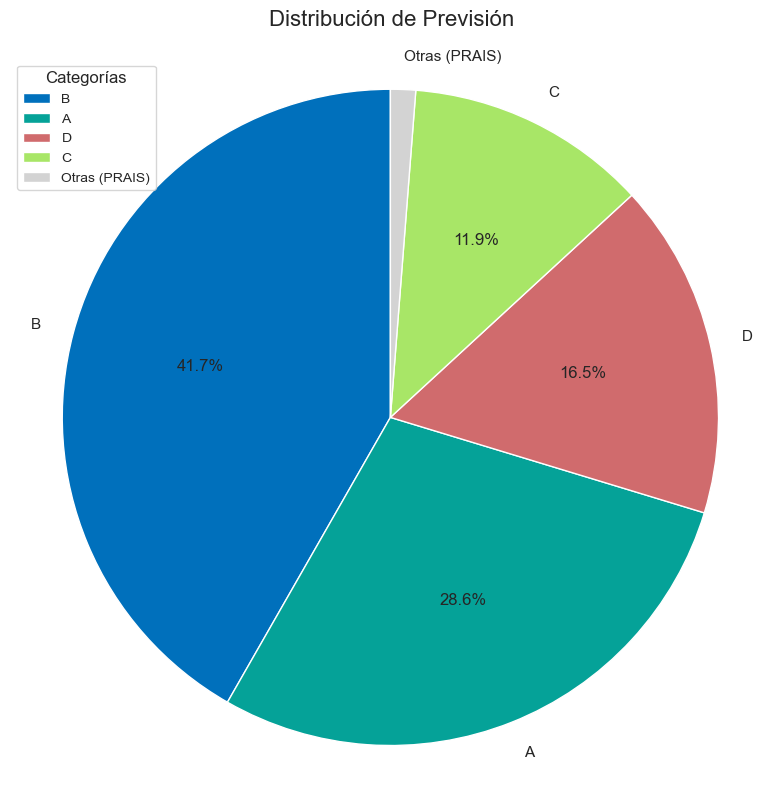

In [47]:
# Set a threshold for categorizing "low-frequency" categories
threshold = (
    prevision.sum() * 0.05
)  # e.g., categories with less than 5% of total sum will be grouped

# Group categories with low frequencies into "Otras (PRAIS)"
prevision_grouped = prevision[prevision >= threshold]
prevision_grouped["Otras (PRAIS)"] = prevision[prevision < threshold].sum()
prevision_grouped = prevision_grouped.sort_values(ascending=False)


# Define a function to hide percentage for "Otras (PRAIS)"
def no_other_pct(pct, allvals):
    absolute = round(pct / 100.0 * sum(allvals), 0)  # Calculate the absolute value from percentage
    if absolute == prevision_grouped["Otras (PRAIS)"]:
        return ""  # Hide percentage for "Otras (PRAIS)" category
    else:
        return f"{pct:.1f}%"  # Format the percentage for other categories


# Create a prettier pie plot
fig, ax = plt.subplots(figsize=(8, 8))  # Larger figure for better clarity
prevision_grouped.plot(
    kind="pie",
    ax=ax,
    autopct=lambda pct: no_other_pct(pct, prevision_grouped),  # Use custom function for percentage
    startangle=90,
    labels=prevision_grouped.index,
    # pctdistance=1.2,  # Move percentage labels outside the pie (optional)
    # labeldistance=1.4,  # Move category labels outside the pie (optional)
)

# Set title and adjust layout
fig.suptitle("Distribución de Previsión", fontsize=16)  # Adjust 'y' to move title upwards
ax.set_ylabel("")  # Remove y-axis label for better clarity

# Add a legend with specific settings
ax.legend(title="Categorías", loc="upper left", fontsize=10)

# Make sure the pie is displayed as a circle
ax.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.tight_layout()

# Save the plot as a PNG file with 300 DPI
plt.savefig("../reports/figures/distribucion_prevision.png", dpi=300)

plt.show()

In [46]:
map_df = gpd.read_file("../data/raw/mapas/Regional.shp")

In [30]:
# Join the data
resumen_regiones = map_df.set_index("Region").join(desglose_por_region)

# Filter the GeoDataFrame to include only the polygons within the bounding box
resumen_regiones_filtrado = resumen_regiones.cx[:, :]

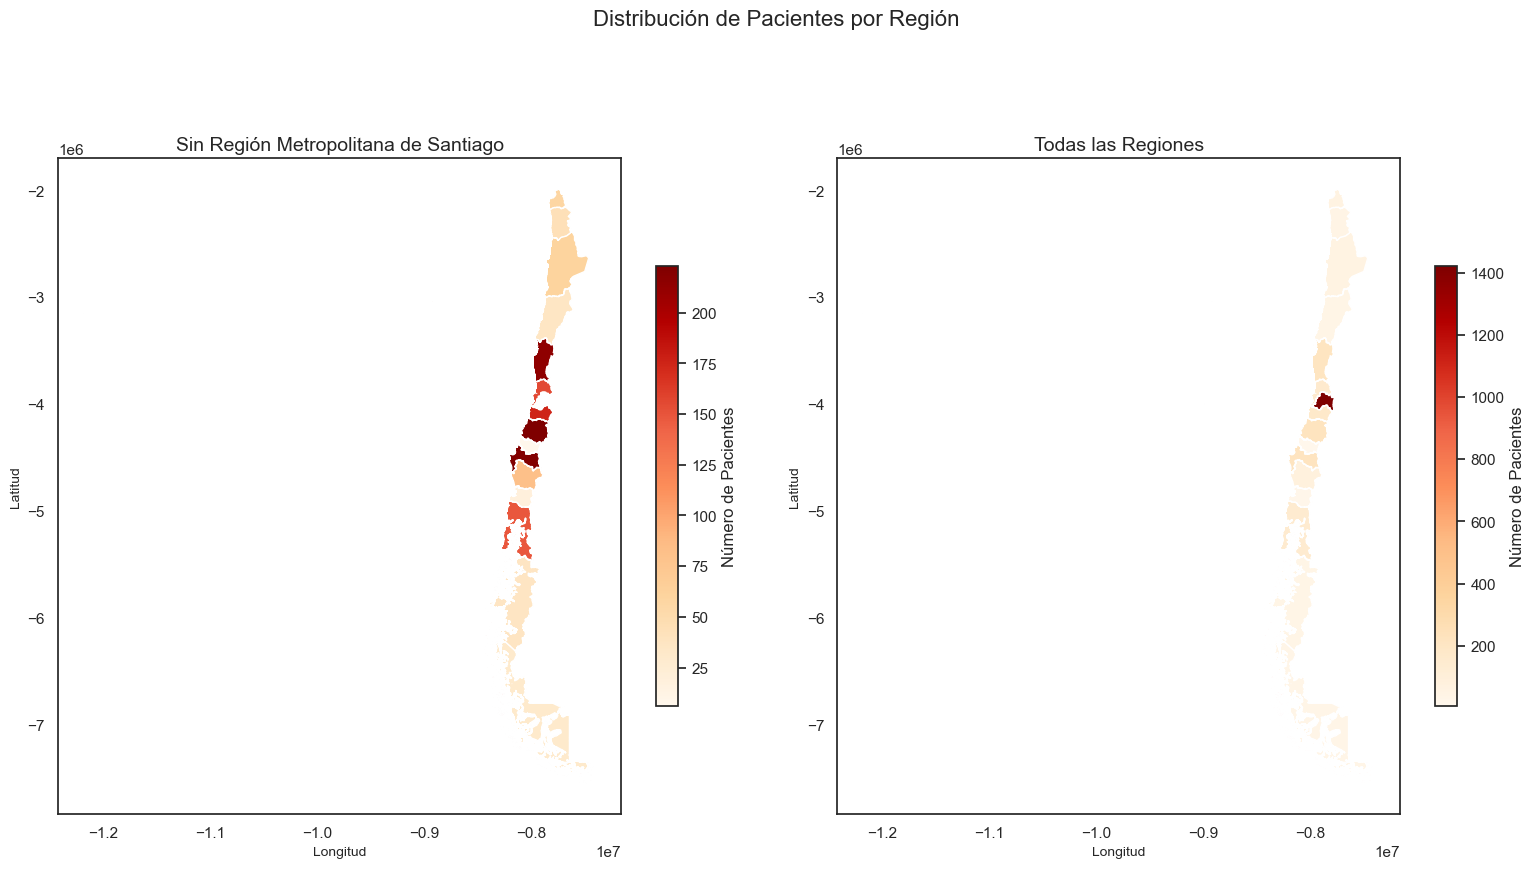

In [31]:
# Set the figure size and aspect ratio
fig, ax = plt.subplots(1, 2, figsize=(16, 10))  # Wider layout for better separation of subplots

# Plot the filtered GeoDataFrame without the specified region on the first subplot
resumen_regiones_filtrado.query("Region != 'Región Metropolitana de Santiago'").plot(
    column="rut",
    cmap="OrRd",
    ax=ax[0],
    legend=True,
    legend_kwds={
        "shrink": 0.5,  # Shrink the colorbar to 50% of its original size
        "label": "Número de Pacientes",  # Add a label to the colorbar
        "orientation": "vertical"  # Keep the legend vertical
    }
)

# Plot the filtered entire GeoDataFrame on the second subplot
resumen_regiones_filtrado.plot(
    column="rut",
    cmap="OrRd",
    ax=ax[1],
    legend=True,
    legend_kwds={
        "shrink": 0.5,  # Match the size of the colorbar with the first subplot
        "label": "Número de Pacientes",
        "orientation": "vertical"
    }
)

# Set titles for each subplot
ax[0].set_title("Sin Región Metropolitana de Santiago", fontsize=14)
ax[1].set_title("Todas las Regiones", fontsize=14)

# Add axis labels for clarity
for axis in ax:
    axis.set_xlabel("Longitud", fontsize=10)
    axis.set_ylabel("Latitud", fontsize=10)

# Overall plot title
fig.suptitle("Distribución de Pacientes por Región", fontsize=16, y=0.95)

# Adjust spacing between plots and tighten layout
plt.tight_layout(pad=2)

# Show the plot
plt.show()